In [1]:
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
# import all stock prices
df = pd.read_csv("NASDAQ_Composite.csv", index_col = 0)
df.head()

,IXIC.Open,IXIC.High,IXIC.Low,IXIC.Close,IXIC.Volume,IXIC.Adjusted
TIMESTAMP,,,,,,
2010-01-04,2294.409912,2311.149902,2294.409912,2308.419922,1.931380e+09,2308.419922
2010-01-05,2307.270020,2313.729980,2295.620117,2308.709961,2.367860e+09,2308.709961
2010-01-06,2307.709961,2314.070068,2295.679932,2301.090088,2.253340e+09,2301.090088
2010-01-07,2298.090088,2301.300049,2285.219971,2300.050049,2.270050e+09,2300.050049
2010-01-08,2292.239990,2317.600098,2290.610107,2317.169922,2.145390e+09,2317.169922


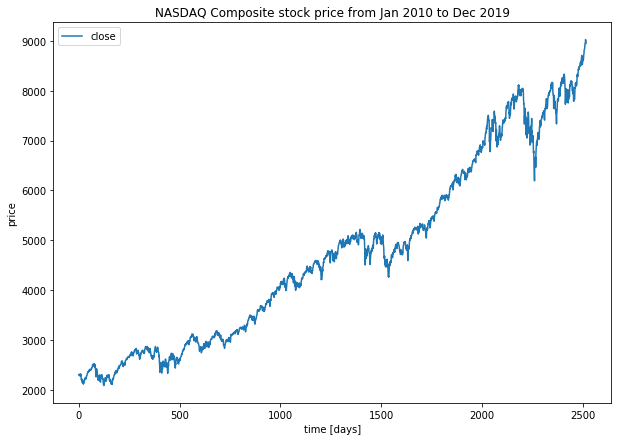

In [3]:
plt.figure(figsize=(10, 7))
plt.plot(df['IXIC.Close'].values, label='close')
plt.title('NASDAQ Composite stock price from Jan 2010 to Dec 2019')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')

# Data Preparation

Before we can fit an LSTM model to the dataset, we must transform the data.

The following three data transforms are performed on the dataset prior to fitting a model and making a forecast.

- Transform the time series data so that it is stationary. Specifically, a lag=1 differencing to remove the increasing trend in the data.
- Transform the time series into a supervised learning problem. Specifically, the organization of data into input and output patterns where the observation at the previous time step is used as an input to forecast the observation at the current time step.
- Transform the observations to have a specific scale. Specifically, to rescale the data to values between -1 and 1 to meet the default hyperbolic tangent activation function of the LSTM model.

These transforms are inverted on forecasts to return them into their original scale before calculating and error score.

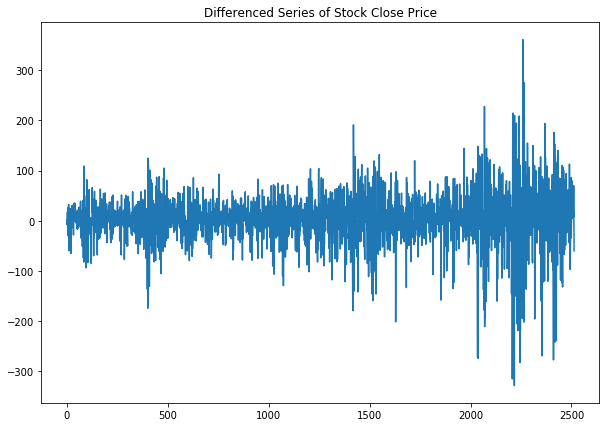

In [4]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

raw_values = df['IXIC.Close'].values
diff_values = difference(raw_values, 1)
plt.figure(figsize=(10, 7))
plt.plot(diff_values)
plt.title('Differenced Series of Stock Close Price')
plt.show()

In [5]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    return df

# transform data to be supervised learning
features = 1
supervised = timeseries_to_supervised(diff_values, features)
supervised_values = supervised.values[features:,:]
print(supervised_values.shape)

(2513, 2)


# Data Split

The data from Jan 2010 to Dec 2018 will be taken for the training dataset and the remaining one year of data will be used for the test set.

Models will be developed using the training dataset and will make predictions on the test dataset.

In [6]:
# split the dataset into two parts: a training set (2010-2018) and a test set (2019).
df_train = df['2010-01-01':'2018-12-31']
df_test = df['2019-01-01':'2019-12-31']
print('Length of data from Jan 2010 to Dec 2018 is', df_train.shape[0])
print('Length of data from Jan 2019 to Dec 2019 is', df_test.shape[0])

Length of data from Jan 2010 to Dec 2018 is 2264
Length of data from Jan 2019 to Dec 2019 is 251


In [7]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [8]:
# split data into train and test-sets
train, test = supervised_values[0:-251, :], supervised_values[-251:, :]
# transform the scale of the data using MinMaxScaler
scaler, train_scaled, test_scaled = scale(train, test)

# LSTM Model

We will use a base stateful LSTM model with 1 neuron fit for 100 epochs.

A batch size of 1 is required as we will be using walk-forward validation and making one-step forecasts for each of the final 251 days of test data.

A batch size of 1 means that the model will be fit using online training (as opposed to batch training or mini-batch training). As a result, it is expected that the model fit will have some variance.

Ideally, more training epochs would be used (such as 1000 or 1500), but this was truncated to 100 to keep run times reasonable.

The model will be fit using the efficient ADAM optimization algorithm and the mean squared error loss function.


# Model Evaluation

A rolling-forecast scenario will be used, also called walk-forward model validation.

Each time step of the test dataset will be walked one at a time. A model will be used to make a forecast for the time step, then the actual expected value from the test set will be taken and made available to the model for the forecast on the next time step.

This mimics a real-world scenario where new close stock price observations would be available each day and used in the forecasting of the next day.

This will be simulated by the structure of the train and test datasets.

All forecasts on the test dataset will be collected and an error score calculated to summarize the skill of the model. The root mean squared error (RMSE) will be used as it punishes large errors and results in a score that is in the same units as the forecast data.

In [9]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# Experimental Runs

Each experimental scenario will be run 10 times.

The reason for this is that the random initial conditions for an LSTM network can result in very different results each time a given configuration is trained.

Let’s dive into the experiments.

In [10]:
# experiment
repeats = 10
error_scores = list()
for r in tqdm(range(repeats)):
    # fit the base model
    lstm_model = fit_lstm(train_scaled, 1, 100, 1)
    # forecast test dataset
    predictions = list()
    for i in range(len(test_scaled)):
        # predict
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
    # report performance
    rmse = sqrt(mean_squared_error(raw_values[-251:], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)

 10%|█         | 1/10 [03:00<27:04, 180.55s/it]

1) Test RMSE: 77.052


 20%|██        | 2/10 [06:08<24:23, 182.91s/it]

2) Test RMSE: 77.298


 30%|███       | 3/10 [09:25<21:48, 186.98s/it]

3) Test RMSE: 76.965


 40%|████      | 4/10 [12:35<18:46, 187.77s/it]

4) Test RMSE: 76.872


 50%|█████     | 5/10 [15:29<15:18, 183.77s/it]

5) Test RMSE: 76.983


 60%|██████    | 6/10 [18:21<12:01, 180.32s/it]

6) Test RMSE: 76.961


 70%|███████   | 7/10 [21:16<08:55, 178.65s/it]

7) Test RMSE: 77.474


 80%|████████  | 8/10 [24:05<05:51, 175.85s/it]

8) Test RMSE: 76.872


 90%|█████████ | 9/10 [26:59<02:55, 175.30s/it]

9) Test RMSE: 76.968


100%|██████████| 10/10 [29:50<00:00, 179.04s/it]

10) Test RMSE: 76.872


Text(0.5, 1.0, 'Box Plot of RMSE from 10 experiment')

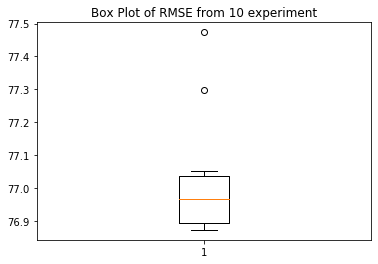

In [11]:
plt.boxplot(error_scores)
plt.title('Box Plot of RMSE from 10 experiment')

In [12]:
np.mean(error_scores)

77.03170345352157